In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
file_path = "Twitter_Data.csv"
df = pd.read_csv(file_path)

# Drop missing values in both columns
df = df.dropna(subset=['clean_text', 'category'])

# Convert sentiment labels to integers
df['category'] = df['category'].astype(int)

[nltk_data] Downloading package stopwords to /Users/harsh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/harsh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/harsh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


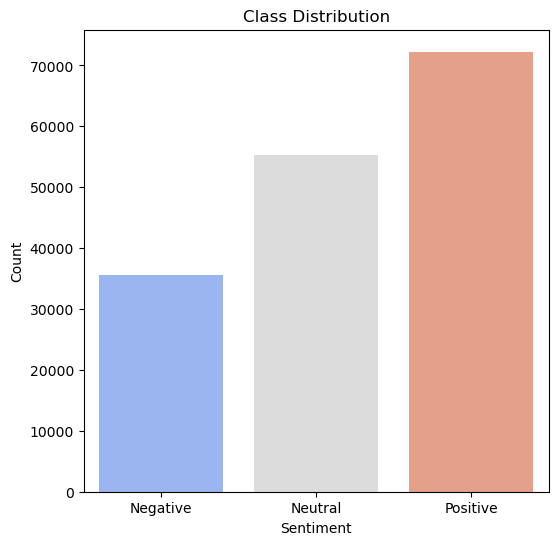

In [3]:
# Check for class imbalance
plt.figure(figsize=(6, 6))
sns.countplot(x=df['category'], palette="coolwarm")
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [4]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Keep important words for sentiment analysis
stop_words.discard("not")
stop_words.discard("no")
stop_words.discard("never")

In [5]:
# Optimized Text Preprocessing Function
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation & special characters
    words = nltk.word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  # Lemmatization
    return ' '.join(words)

# Apply preprocessing
df['clean_text'] = df['clean_text'].apply(preprocess_text)

# Split dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['category'], test_size=0.3, random_state=42, stratify=df['category'])

In [6]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=8000,  # Reduce features for generalization
    ngram_range=(1, 2),  # Use unigrams + bigrams
    max_df=0.7,  # Ignore words appearing in >70% of tweets
    min_df=5,  # Ignore very rare words appearing in <5 tweets
    sublinear_tf=True  # Scale term frequencies logarithmically
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [13]:
# ✅ Handle Class Imbalance using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# ✅ Hyperparameter Tuning for Logistic Regression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.5, 1.0, 2.0, 5.0, 10.0]}  # Test different regularization strengths

grid = GridSearchCV(
    LogisticRegression(solver='saga', max_iter=500),
    param_grid,
    cv=5,  # 5-Fold Cross Validation
    scoring='accuracy',
    n_jobs=-1  # Use all CPU cores for speed
)

# ✅ Train Logistic Regression with different C values
grid.fit(X_train_resampled, y_train_resampled)

# ✅ Get Best C Value
best_C = grid.best_params_['C']
print(f"🔥 Best C Value: {best_C}")

# ✅ Train Final Model with Best C Value
model = LogisticRegression(solver='saga', max_iter=500, C=best_C)
model.fit(X_train_resampled, y_train_resampled)


🔥 Best C Value: 10.0


LogisticRegression(C=10.0, max_iter=500, solver='saga')

In [14]:
# ✅ Train Final Model with Best C from GridSearch
model = LogisticRegression(solver='saga', max_iter=500, C=best_C)
model.fit(X_train_resampled, y_train_resampled)


LogisticRegression(C=10.0, max_iter=500, solver='saga')

In [20]:
# Evaluate Performance
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f" Model Accuracy: {accuracy:.2%}\n")

 Model Accuracy: 86.59%



In [21]:
# Classification Report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.79      0.79     10653
     Neutral       0.85      0.93      0.88     16563
    Positive       0.92      0.86      0.89     21675

    accuracy                           0.87     48891
   macro avg       0.85      0.86      0.85     48891
weighted avg       0.87      0.87      0.87     48891



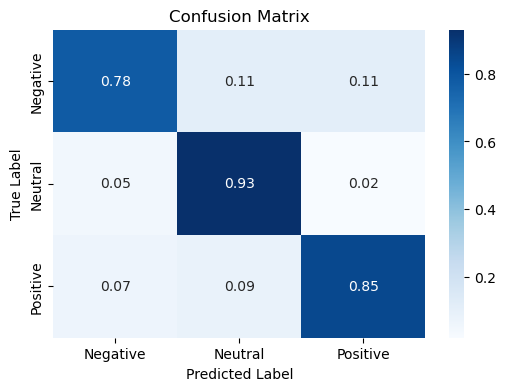

In [18]:
# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# Function for manual tweet testing
def predict_sentiment(tweet):
    cleaned_tweet = preprocess_text(tweet)
    vectorized_tweet = vectorizer.transform([cleaned_tweet])
    prediction = model.predict(vectorized_tweet)[0]
    return {-1: "Negative", 0: "Neutral", 1: "Positive"}[prediction]

# Example Predictions
test_tweets = ["I love this product!", "This is the worst experience ever!", "It's okay, not great."]
for tweet in test_tweets:
    print(f"Tweet: {tweet} --> Sentiment: {predict_sentiment(tweet)}")


Tweet: I love this product! --> Sentiment: Positive
Tweet: This is the worst experience ever! --> Sentiment: Negative
Tweet: It's okay, not great. --> Sentiment: Positive
